# Overview
In the following example we will walk through how we can leverage the `clouddrift` library to do something interesting with the HURDAT2 dataset. Simply put, the HURDAT2 dataset is a dataset that contains storm track data (including other measurements such as pressure, wind speed, etc...) for storms recorded from 1852 - 2022 across both the pacific and atlantic ocean.

To get things in motion lets import the `adapters` module from clouddrift and load the dataset into the `ds` variable


We convert the ragged array into an xarray `Dataset` to leverage some of the powerful 
subsetting utilities provided by the data structure that helps power the `subset` function.

Lets load in the HURDAT2 dataset, which contains the track data:

In [1]:
import clouddrift
hurdat2_ds = clouddrift.datasets.hurdat2(decode_times=True)
hurdat2_ds

<xarray.Dataset> Size: 13MB
Dimensions:                          (traj: 3143, obs: 84188)
Coordinates:
    id                               (traj) int64 25kB ...
    time                             (obs) datetime64[ns] 674kB ...
Dimensions without coordinates: traj, obs
Data variables: (12/23)
    basin                            (traj) <U2 25kB ...
    atcf_identifier                  (traj) <U8 101kB ...
    year                             (traj) int64 25kB ...
    rowsize                          (traj) int64 25kB ...
    record_identifier                (obs) <U1 337kB ...
    system_status                    (obs) <U2 674kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 674kB ...
    max_high_wind_radius_ne          (obs) float64 674kB ...
    max_high_wind_radius_se          (obs) float64 674kB ...
    max_high_wind_radius_sw          (obs) float64 674kB ...
    max_high_wind_radius_nw          (obs) float64 674kB ...
    max_sustained_wind_speed_radius  (obs) float64 674kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-03-24T21:39:49.842599
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

Lets load in the GDP 6-hourly dataset which records data variables on a 6-hour period. We will only select a subset of them as even before filtering as the full dataset can take a while to download.

In [7]:
gdp6h_ds = clouddrift.adapters.gdp6h.to_raggedarray(n_random_id=1000).to_xarray()
gdp6h_ds

Retrieving the number of obs: 100%|█████████| 1000/1000 [00:10<00:00, 94.24it/s]
/home/ksantana/miniconda3/envs/hurdat2-get-started/lib/python3.12/site-packages/xarray/conventions.py:440: SerializationWarning: variable 'WMO' has multiple fill values {'-999999', -999999}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
Filling the Ragged Array: 100%|█████████████| 1000/1000 [00:50<00:00, 19.71it/s]


<xarray.Dataset> Size: 83MB
Dimensions:                (traj: 1000, obs: 1687118)
Coordinates:
    id                     (traj) int64 8kB 7702201 7702218 ... 300534062099810
    time                   (obs) float64 13MB 2.879e+08 2.879e+08 ... 1.697e+09
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    rowsize                (traj) int32 4kB 1747 1057 668 2008 ... 31 96 70 53
    WMO                    (traj) int32 4kB 0 0 0 0 ... 1701674 2802070 6203890
    expno                  (traj) int32 4kB 40 73 8129 129 ... 31412 31412 21421
    deploy_date            (traj) float32 4kB 2.878e+08 2.976e+08 ... 1.696e+09
    deploy_lat             (traj) float32 4kB -4.9 2.0 4.15 ... nan 5.02 9.9
    deploy_lon             (traj) float32 4kB -84.0 -105.0 ... -170.0 -22.82
    ...                     ...
    vn                     (obs) float32 7MB nan 0.1734 0.1955 ... -0.2809 nan
    temp                   (obs) float32 7MB nan nan nan ... 28.95 29.21 29.43
    err_lat                (obs) float32 7MB 0.01113 0.02416 ... 0.001659
    err_lon                (obs) float32 7MB 0.007231 0.01556 ... 0.002471
    err_temp               (obs) float32 7MB 0.1182 0.1418 ... 0.03665 0.03665
    drogue_status          (obs) bool 2MB True True True True ... True True True
Attributes: (12/18)
    title:                Global Drifter Program drifting buoy collection
    history:              version September 2023. Metadata from dirall.dat an...
    Conventions:          CF-1.6
    time_coverage_start:  1979-02-15:00:00:00Z
    time_coverage_end:    2023-10-14:18:00:00Z
    date_created:         2024-03-26T00:22:53.842719
    ...                   ...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    institution:          NOAA Atlantic Oceanographic and Meteorological Labo...
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    summary:              Global Drifter Program six-hourly data
    doi:                  10.25921/7ntx-z961

Now lets say that we'd like to select a specific subset of this dataset; we can leverage the `subset` utility function provided through the `ragged` module which contains a library of helpful utility functions for working with the `RaggedArray` data structure.

As an example say you wanted a subset of the dataset for storms whose track lied within the Atlantic Ocean and was tracked between August and October of 2020. You can leverage the `subset` function to help you achieve this by first defining the criteria:

In [8]:
# import some helpful libraries
import numpy as np
from datetime import datetime

# define the critieria
# Here the datasets variables are mapped to an (inclusive start and end) range
hurdat2_criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        np.datetime64(int(datetime(2020, 8, 1).timestamp()), "s"),
        np.datetime64(int(datetime(2020, 10, 1).timestamp()), "s")
    )
)


gdp_criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        datetime(2020, 8, 1).timestamp(),
        datetime(2020, 10, 1).timestamp(),
    )
)

Lets import the function and apply the criteria to the dataset. 

Here we need to provide the row dimensions alias which is `traj` in the hurdat2 dataset.

In [9]:
from clouddrift.ragged import subset

hurdat2_subset_ds = subset(hurdat2_ds, hurdat2_criteria, row_dim_name="traj")
hurdat2_subset_ds

<xarray.Dataset> Size: 50kB
Dimensions:                          (traj: 14, obs: 313)
Coordinates:
    id                               (traj) int64 112B 3034 3035 ... 3055 3056
    time                             (obs) datetime64[ns] 3kB 2020-08-01T06:0...
Dimensions without coordinates: traj, obs
Data variables: (12/23)
    basin                            (traj) <U2 112B ...
    atcf_identifier                  (traj) <U8 448B ...
    year                             (traj) int64 112B ...
    rowsize                          (traj) int64 112B 19 4 24 7 ... 48 24 7 17
    record_identifier                (obs) <U1 1kB ...
    system_status                    (obs) <U2 3kB ...
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 3kB ...
    max_high_wind_radius_ne          (obs) float64 3kB ...
    max_high_wind_radius_se          (obs) float64 3kB ...
    max_high_wind_radius_sw          (obs) float64 3kB ...
    max_high_wind_radius_nw          (obs) float64 3kB ...
    max_sustained_wind_speed_radius  (obs) float64 3kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-03-24T21:39:49.842599
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

In [10]:
gdp6h_subset_ds = subset(gdp6h_ds, gdp_criteria, row_dim_name="traj")
gdp6h_subset_ds

<xarray.Dataset> Size: 89kB
Dimensions:                (traj: 9, obs: 1763)
Coordinates:
    id                     (traj) int64 72B 300234063999460 ... 300234066315070
    time                   (obs) float64 14kB 1.596e+09 1.596e+09 ... 1.602e+09
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    rowsize                (traj) int64 72B 244 244 244 112 244 244 142 244 45
    WMO                    (traj) int32 36B 1301525 4101548 ... 1701631 4101789
    expno                  (traj) int32 36B 21312 31312 2222 ... 21312 21312
    deploy_date            (traj) float32 36B 1.49e+09 1.501e+09 ... 1.6e+09
    deploy_lat             (traj) float32 36B 20.13 27.0 6.0 ... 13.03 28.99
    deploy_lon             (traj) float32 36B -34.03 -79.29 ... -46.01 -62.46
    ...                     ...
    vn                     (obs) float32 7kB -0.1894 0.01647 ... 0.02733 0.06306
    temp                   (obs) float32 7kB 22.47 22.49 22.65 ... 26.33 26.32
    err_lat                (obs) float32 7kB 0.002629 0.002635 ... 0.001692
    err_lon                (obs) float32 7kB 0.00327 0.003277 ... 0.002558
    err_temp               (obs) float32 7kB 0.03662 0.03662 ... 0.03261 0.04632
    drogue_status          (obs) bool 2kB False False False ... False False
Attributes: (12/18)
    title:                Global Drifter Program drifting buoy collection
    history:              version September 2023. Metadata from dirall.dat an...
    Conventions:          CF-1.6
    time_coverage_start:  1979-02-15:00:00:00Z
    time_coverage_end:    2023-10-14:18:00:00Z
    date_created:         2024-03-26T00:22:53.842719
    ...                   ...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    institution:          NOAA Atlantic Oceanographic and Meteorological Labo...
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    summary:              Global Drifter Program six-hourly data
    doi:                  10.25921/7ntx-z961

Lets generate an array we can utilize to determine the start and end index of each trajectories segment of the ragged array.

In [11]:
# Lets generate an array identifying the start and end index of each trajectories segment on the RaggedArray data structure 
hurdat2_obs_range = np.cumsum(np.array([0, *hurdat2_ds["rowsize"]]))
hurdat2_obs_range

array([    0,    14,    15, ..., 84143, 84167, 84188])

In [12]:
# Lets also do this for the drifters
gdp6h_obs_range  = np.cumsum(np.array([0, *gdp6h_ds["rowsize"]]))
gdp6h_obs_range

array([      0,    1747,    2804, ..., 1686995, 1687065, 1687118])

In [13]:
# ids that match the criteria
all_storms = hurdat2_ds["id"].to_numpy().tolist()
storm_ids = hurdat2_subset_ds["id"].to_numpy().tolist()
storm_ids, all_storms

([3034,
  3035,
  3037,
  3039,
  3042,
  3046,
  3047,
  3049,
  3050,
  3051,
  3052,
  3054,
  3055,
  3056],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  1

In [14]:
all_drifters = gdp6h_ds["id"].to_numpy().tolist()
drifter_ids = gdp6h_subset_ds["id"].to_numpy().tolist()
drifter_ids

[300234063999460,
 300234063515980,
 300234065748640,
 300234065705130,
 300234066439880,
 300234066713580,
 300234068244510,
 300234067540310,
 300234066315070]

(10.0, 80.0)

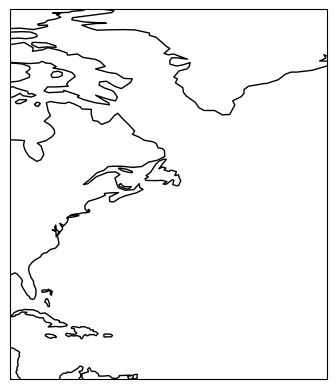

In [21]:
import cartopy.crs as ccrs  # cartopy for projecting our dataset onto different map projections
import matplotlib.pyplot as plt # is an standard plotting library
import matplotlib.animation as animation

fig = plt.figure()

ax = fig.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=-5)))
ax.coastlines()

ax.set_xlim((-80, -20))
ax.set_ylim((10, 80))

In [22]:
lines = list()

for storm_id in storm_ids:
    idx = all_storms.index(storm_id)
    start, end = hurdat2_obs_range[idx], hurdat2_obs_range[idx+1]
    selected = slice(start, end)
    selected_lon, selected_lat = hurdat2_ds["lon"].isel(obs=selected), hurdat2_ds["lat"].isel(obs=selected)
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="--", linewidth=2,
        transform=ccrs.PlateCarree()
    )
    lines.append((selected_lon, selected_lat, line[0]))

for drifter_id in drifter_ids:
    idx = all_drifters.index(drifter_id)
    start, end = gdp6h_obs_range[idx], gdp6h_obs_range[idx+1]
    selected = slice(start, end)
    selected_lon, selected_lat = gdp6h_ds["lon"].isel(obs=selected), gdp6h_ds["lat"].isel(obs=selected)
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=2,
        transform=ccrs.PlateCarree()
    )
    lines.append((selected_lon, selected_lat, line[0]))

def update(frame):
    for selected_lon, selected_lat, line in lines:
        line.set_xdata(selected_lon[:frame])
        line.set_ydata(selected_lat[:frame])
    return lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=1000, interval=50)
ani.save("storm_drifters.gif")
plt.show()